# Baseline model for batch monitoring example

In [2]:
import requests
import datetime
import pandas as pd
import matplotlib as plt

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric

from joblib import load, dump
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

AttributeError: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

In [3]:
import evidently
print(evidently.__file__)


/Users/isabellevea/anaconda3/envs/py11/lib/python3.11/site-packages/evidently/__init__.py


In [4]:
files= [('green_tripdata_2023-02.parquet','./data'),('green_tripdata_2023-01.parquet','./data')]

In [6]:
print("Download files:")

for file, path in files:
    url=f'https://d37ci6vzurychx.cloudfront.net/trip-data/{file}'
    resp=requests.get(url, stream=True)
    save_path=f'{path}/{file}'
    with open(save_path,"wb") as handle:
        for data in tqdm(resp.iter_content(),
                         desc=f'{file}',
                         postfix=f"save to {save_path}",
                         total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2023-01.parquet: 100%|██████████| 1427002/1427002 [00:12<00:00, 116020.94it/s, save to ./data/green_tripdata_2023-01.parquet]


In [33]:
jan_data = pd.read_parquet("data/green_tripdata_2023-01.parquet")

In [34]:
jan_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,68211.000000,68211,68211,63887.000000,68211.000000,68211.000000,63887.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,68211.000000,63887.000000,63877.000000,63887.000000
mean,1.863028,2023-01-16 20:10:55.679523,2023-01-16 20:29:01.515767,1.117160,98.549735,138.429901,1.315870,8.114852,16.603545,0.825431,0.588340,2.139012,0.169627,0.951625,21.789377,1.373613,1.021933,0.726748
min,1.000000,2009-01-01 20:21:27,2009-01-02 11:07:31,1.000000,1.000000,1.000000,0.000000,0.000000,-70.000000,-2.500000,-0.500000,-10.500000,0.000000,-1.000000,-71.500000,1.000000,1.000000,-2.750000
25%,2.000000,2023-01-09 11:59:47.500000,2023-01-09 12:16:37.500000,1.000000,74.000000,74.000000,1.000000,1.110000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,12.900000,1.000000,1.000000,0.000000
50%,2.000000,2023-01-17 08:40:42,2023-01-17 08:56:38,1.000000,75.000000,138.000000,1.000000,1.850000,13.500000,0.000000,0.500000,1.600000,0.000000,1.000000,17.900000,1.000000,1.000000,0.000000
75%,2.000000,2023-01-24 15:52:30,2023-01-24 16:06:56,1.000000,129.000000,219.000000,1.000000,3.210000,19.800000,1.000000,0.500000,3.330000,0.000000,1.000000,26.150000,2.000000,1.000000,2.750000
max,2.000000,2023-02-01 03:10:05,2023-02-01 17:27:05,99.000000,265.000000,265.000000,9.000000,120098.840000,490.000000,12.500000,2.750000,222.220000,36.050000,1.000000,491.000000,5.000000,2.000000,2.750000
std,0.343820,NaN,NaN,1.372913,61.244314,76.761311,0.979054,585.105955,13.470121,1.269904,0.385819,3.052710,1.099789,0.196875,15.457115,0.508039,0.146465,1.212836


In [35]:
jan_data.shape

(68211, 20)

In [36]:
#target

jan_data['duration_min'] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td: float(td.total_seconds()/60))

In [37]:
#removing outliers
jan_data = jan_data[(jan_data.duration_min >= 0)&(jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count >= 0)&(jan_data.passenger_count <= 8)]


<Axes: >

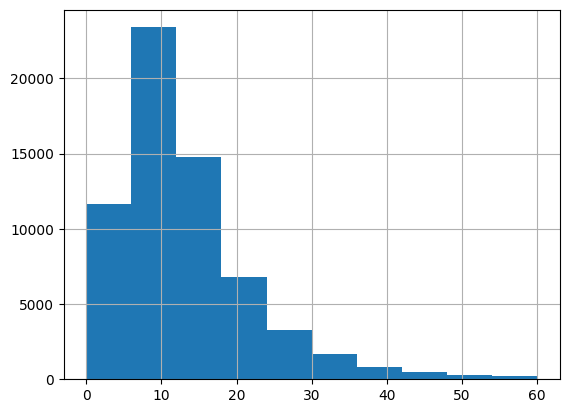

In [38]:
#target distribution
jan_data.duration_min.hist()

In [39]:
#data labeling
target ='duration_min'
num_features= ['passenger_count', 'trip_distance', 'fare_amount', 'total_amount']
cat_features = ['PULocationID', 'DOLocationID']

In [40]:
jan_data.shape

(63295, 21)

In [41]:
jan_data.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag           0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
passenger_count              0
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                63295
improvement_surcharge        0
total_amount                 0
payment_type                 0
trip_type                    5
congestion_surcharge         0
duration_min                 0
dtype: int64

In [42]:
jan_data=jan_data.dropna(subset=['payment_type', 'trip_type'])


In [43]:
jan_data.shape

(63290, 21)

In [44]:
train_data=jan_data[:40000]
val_data=jan_data[40000:]

In [45]:
train_data.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag           0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
passenger_count              0
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                40000
improvement_surcharge        0
total_amount                 0
payment_type                 0
trip_type                    0
congestion_surcharge         0
duration_min                 0
dtype: int64

In [46]:
val_data.isnull().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag           0
RatecodeID                   0
PULocationID                 0
DOLocationID                 0
passenger_count              0
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                23290
improvement_surcharge        0
total_amount                 0
payment_type                 0
trip_type                    0
congestion_surcharge         0
duration_min                 0
dtype: int64

In [47]:
model = LinearRegression()

In [48]:
model.fit(train_data[num_features+cat_features],train_data[target])

LinearRegression()

In [49]:
train_preds=model.predict(train_data[num_features+cat_features])
train_data['prediction']=train_preds

/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_85027/3195417983.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prediction']=train_preds


In [50]:
val_preds=model.predict(val_data[num_features+cat_features])
val_data['prediction']=val_preds

/var/folders/dd/nb8m5vwd1sz3_s49jh1plcfr0000gn/T/ipykernel_85027/959123884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['prediction']=val_preds


In [51]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.5728214556817
3.605280733551226


# Dump model and reference data
we have to save the reference data to compare and monitor model performance

In [52]:
#saving model into models/
with open('models/lin_reg.bin','wb') as f_out:
    dump(model,f_out)
          

In [53]:
#saving reference data (which is the validation dataset)
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [59]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [60]:
report=Report(
    metrics=[
        ColumnDriftMetric(column_name='prediction'),
        DatasetDriftMetric(),
        DatasetMissingValuesMetric()
    ]
)

NameError: name 'Report' is not defined